# Notebook Intro

In this notebook, we scrape search term engagement with different shows for a model that was not included in the end product.

##  Imports / TrendReq with pytrend

In [1]:
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from pytrends.request import TrendReq
import datetime as datetime

pytrend = TrendReq(timeout=None)

# Web Scraping Request - Building

## Pre-Designed Table Import

In [ ]:
# Web scraped data from "web_scraping" notebook
show_details = pd.read_csv('data/ibdb_show_details.csv')
show_stops = pd.read_csv('data/idbd_show_stops.csv')

# Queried dataset from Open Broadway Data for all Broadway NYC shows since 2000
nyc_shows = pd.read_csv('data/open_broadway_data_shows_since_2000.csv')

# Tony Award winner data, scraped for Film-to-Broadway linear regression model 
tony_winners = pd.read_csv('data/tonys_tony_winners_list.csv')

list_of_cities = pd.read_csv('data/list_of_cities.csv')

## Function Build

In [25]:
# Test values are for Mean Girls' performance in Cleveland
show_title = ['Mean Girls Musical']
nyc_opening = '2018-04-08'
nyc_closing = 'N/A'
tour_opening = '2019-09-21'
tour_venue_opening = '2019-12-03'
tour_venue_closing = '2019-12-22' 
location_tag = 'US-OH-510'

# convert opening night value to datetime and go back three months in time
# code found at https://www.programiz.com/python-programming/datetime/strftime
datetime_opening = dt.strptime(nyc_opening, '%Y-%m-%d')
# set relative time delta
three_mon_rel = relativedelta(months=-3)
# Back in time! 
starting_point_dt = datetime_opening + three_mon_rel
# Reset date to string
starting_point = starting_point_dt.strftime('%Y-%m-%d')

# Repeat process for, add one date to end of closing
datetime_closing = dt.strptime(tour_venue_closing, '%Y-%m-%d')
one_mon_rel = relativedelta(months=1)
ending_point_dt = datetime_closing + one_mon_rel
ending_point = ending_point_dt.strftime('%Y-%m-%d')

# Search for term in geographic area
pytrend.build_payload(kw_list=show_title, timeframe=f'{starting_point} {ending_point}', geo=f'{location_tag}')
# set to table
interest_over_time_df = pytrend.interest_over_time()

# rename columns for graphing ease
interest_over_time_df.columns = [ 'frequency', 'isPartial']

# add search_term and geo_code for later reference
interest_over_time_df['search_term'] = show_title[0]
interest_over_time_df['geo_code'] = location_tag

## Table Transformations / Merging

In [6]:
# show_details transformation - dropped index column and added title clarifier for merge 

show_details = show_details.drop(columns=['Unnamed: 0'])
show_details['tour_descript'] = show_details['title']
show_details['title'] = [title.split(' (')[0] for title in show_details['title']]

nyc_shows = nyc_shows.drop(columns='Unnamed: 0')
nyc_shows.columns = ['title', 'year', 'opening_date', 'closing_date',
                     'production_type', 'show_type', 'n_performances']

In [7]:
full_details = pd.merge(show_details, nyc_shows, on='title',how='inner')

In [8]:
full_details = full_details.drop(columns=['Unnamed: 0.1'])

In [9]:
full_details.columns = ['title', 'tour_descript', 'show_type_tour', 'tour_opening', 'tour_closing',
       'original_or_revival', 'reference_url', 'year_tour', 'year_nyc',
       'opening_date', 'closing_date', 'production_type', 'show_type_nyc',
       'n_performances_nyc']

In [10]:
# Create table of shows since 2003, with the tour two or less years after the NYC debut

shows_since_2003 = full_details[full_details.year_tour>2003]
shows_since_2003 = shows_since_2003[shows_since_2003.year_tour + 3 > shows_since_2003.year_nyc].reset_index(drop=True)

# Moved for some manual removal of data
#shows_since_2003.to_csv('data/open_broadway_data_shows_since_2003.csv')

In [11]:
shows_since_2003 = pd.read_csv('data/open_broadway_data_shows_since_2003.csv')
shows_since_2003 = shows_since_2003.drop(columns=['Unnamed: 0'])

## Tour Route Stop Data

In [13]:
show_stops.dates[0][15:]

'Jul 23, 2017'

In [14]:
opening_list = []
closing_list = []

for i,opening in enumerate(show_stops.dates):
    if len(opening) == 27:
        opening_date = show_stops.dates[i][:12]
        opening_list.append(opening_date)
    else: 
        opening_list.append(show_stops.dates[i][2:])
    
for i,closing in enumerate(show_stops.dates):
    if len(closing) == 27:
        closing_date = show_stops.dates[i][15:]
        closing_list.append(closing_date)
    else:
        closing_list.append(show_stops.dates[i][2:])

In [15]:
show_stops['city_opening_date'] = opening_list
show_stops['city_closing_date'] = closing_list

In [16]:
from datetime import datetime

datetime_openings = []
datetime_closings = []

for date in show_stops.city_opening_date:
    if date[0] != ' ': 
        dt = datetime.strptime(date, '%b %d, %Y')
        datetime_openings.append(dt)
    else:
        datetime_openings.append(date[2:])
    
for date in show_stops.city_closing_date:
    try:
        if date[0] != '-': 
            dt = datetime.strptime(date, '%b %d, %Y')
            datetime_closings.append(dt)
        else:
            datetime_closings.append(date[2:])
    except:
        datetime_closings.append(date[2:])

show_stops['city_opening_date'] = datetime_openings
show_stops['city_closing_date'] = datetime_closings

In [17]:
show_stops.to_csv('data/idbd_show_stops.csv')

In [18]:
cities = pd.DataFrame(show_stops.city.unique())
#cities.to_csv('data/list_of_cities.csv')

## AREA CODE - Return here

In [23]:
area_codes = pd.read_csv('data/github_area_codes.csv')

In [24]:
state_abbreviations = pd.read_csv('data/state_abbreviations.csv')
state_abbreviations.columns = ['state', 'abbrev', 'code']

In [25]:
area_codes_merged = pd.merge(area_codes, state_abbreviations, on='state', how='inner')

city_list = []

for i, city in enumerate(area_codes_merged.city):
    new_city = city + ', ' + area_codes_merged.code[i]
    city_list.append(new_city)
    
area_codes_merged['city'] = city_list

In [78]:
area_codes_merged

,area_code,city,state,country,lat,long,abbrev,code
0,201,"Bayonne, NJ",New Jersey,US,40.66871,-74.11431,N.J.,NJ
1,201,"Bergenfield, NJ",New Jersey,US,40.92760,-73.99736,N.J.,NJ
2,201,"Cliffside Park, NJ",New Jersey,US,40.82149,-73.98764,N.J.,NJ
3,201,"Englewood, NJ",New Jersey,US,40.89288,-73.97264,N.J.,NJ
4,201,"Fair Lawn, NJ",New Jersey,US,40.94038,-74.13181,N.J.,NJ
...,...,...,...,...,...,...,...,...
2761,907,"College, AK",Alaska,US,64.85694,-147.80278,Alaska,AK
2762,907,"Fairbanks, AK",Alaska,US,64.83778,-147.71639,Alaska,AK
2763,907,"Juneau, AK",Alaska,US,58.30194,-134.41972,Alaska,AK
2764,907,"Ketchikan, AK",Alaska,US,55.34225,-131.64784,Alaska,AK


In [396]:
area_codes_merged = area_codes_merged[['area_code', 'city', 'code']]
area_codes_merged = area_codes_merged.drop_duplicates(subset=['city'])
area_codes_merged = area_codes_merged.reset_index(drop=True)

### Do not run

In [ ]:
full_stops_table = pd.merge(show_stops, area_codes_merged, on='city', how='inner')
full_stops_table

In [ ]:
# LIST OF CITIES NOT INCLUDED DUE TO ZIP CODE MISMATCH

show_stops_list = show_stops.city.unique()
merged_list = full_stops_table.city.unique()

for item in show_stops_list:
    if item not in merged_list:
        print(item)

## Add Geo Code to List of Cities - 11/24

In [4]:
code_list = []

for i, value in enumerate(list_of_cities.full_code):
    if type(value)==float:
        state_abbreviation = list_of_cities.city[i][-2:]
        state_code = list_of_cities.geo_code[i]
        new_code= str('US-' + state_abbreviation + '-' + state_code)
        code_list.append(new_code)
    else:
        code_list.append(value)
        
list_of_cities.full_code = code_list
list_of_cities.to_csv('data/list_of_cities.csv')

NameError: name 'list_of_cities' is not defined

In [13]:
full_stops_table = pd.merge(show_stops, list_of_cities, on='city', how='inner')
full_stops_table = full_stops_table.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])
full_stops_table

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,title,city,dates,theatre,city_opening_date,city_closing_date,geo_code,full_code,metro_area_name
0,0,0,0,The Lion King (Tour: Gazelle),"Houston, TX","Jun 27, 2017 - Jul 23, 2017",Hobby Center For The Performing Arts,2017-06-27 00:00:00,2017-07-23 00:00:00,618,US-TX-618,Houston TX
1,58,58,58,The Lion King (Tour: Gazelle),"Houston, TX","Jul 09, 2012 - Aug 12, 2012",Hobby Center For The Performing Arts,2012-07-09 00:00:00,2012-08-12 00:00:00,618,US-TX-618,Houston TX
2,145,145,145,The Lion King (Tour: Gazelle),"Houston, TX","Jul 09, 2002 - Aug 25, 2002",Jones Hall For The Performing Arts,2002-07-09 00:00:00,2002-08-25 00:00:00,618,US-TX-618,Houston TX
3,190,190,190,The Book of Mormon (Tour: Jumamosi),"Houston, TX","Jan 15, 2019 - Jan 20, 2019",Hobby Center For The Performing Arts,2019-01-15 00:00:00,2019-01-20 00:00:00,618,US-TX-618,Houston TX
4,257,257,257,The Book of Mormon (Tour: Jumamosi),"Houston, TX","Jan 03, 2017 - Jan 15, 2017",Hobby Center For The Performing Arts,2017-01-03 00:00:00,2017-01-15 00:00:00,618,US-TX-618,Houston TX
...,...,...,...,...,...,...,...,...,...,...,...,...
21886,21562,21562,21562,1776 (Tour),"Gloucester, VA","Jan 05, 1976 - Jan 05, 1976",Gloucester High School Auditorium,1976-01-05 00:00:00,1976-01-05 00:00:00,556,US-VA-556,Richmond-Petersburg VA
21887,21574,21574,21574,1776 (Tour),"Clarion, PA","Oct 01, 1975 - Oct 01, 1975",Marwick-Boyd Fine Arts Center,1975-10-01 00:00:00,1975-10-01 00:00:00,508,US-PA-508,Pittsburgh PA
21888,21576,21576,21576,1776 (Tour),"Selinsburg, PA","Sep 21, 1975 - Sep 21, 1975",Weber Chapel Auditorium,1975-09-21 00:00:00,1975-09-21 00:00:00,566,US-PA-566,Harrisburg-Lancaster-Lebanon-York PA
21889,21599,21599,21599,The Belle of Amherst (Tour),"Greenwich, CT","Apr 02, 1977 - Apr 02, 1977",Greenwich High School Auditorium,1977-04-02 00:00:00,1977-04-02 00:00:00,CT,US-CT,Connecticut


<h3> Target Function!

<h2> CONSIDER USING TOPIC CODE INSTEAD OF TITLE IF TIME

# Web Scrape Function Development

In [6]:
shows_since_2003 = pd.read_csv('data/open_broadway_data_shows_since_2003.csv')
full_stops_table = pd.read_csv('data/full_stops_table.csv')
table_2 = pd.read_csv('data/final_scraped_data/merged_scrape_3_1127.csv')

In [46]:
completed_list = table_2[table_2.frequency!='collection error'].search_term.unique()
completed_list

array(['The Book of Mormon', 'Jersey Boys', 'Cabaret',
       'An American in Paris', 'Finding Neverland',
       'The Curious Incident of the Dog in the Night-Time',
       'The King and I', 'Fun Home', 'Evita', 'Anything Goes',
       'The Book of Mormon (Tour: Jumamosi)',
       'The Book of Mormon (Tour: Latter Day)', 'Pippin (Tour)',
       "Rodgers + Hammerstein's Cinderella (Tour)", 'Kinky Boots (Tour)',
       'Newsies The Musical (Tour)', 'Jersey Boys (Tour)',
       'Blithe Spirit (Tour)', 'Once (Tour)',
       'Wicked (Tour: Emerald City)', 'Wicked (Tour: Munchkinland)',
       'Wicked (Tour: Chicago)', 'Wicked (Tour: Los Angeles)',
       'Wicked (Tour: San Francisco)', 'Million Dollar Quartet (Tour)',
       'The Bridges of Madison County (Tour)', 'If/Then (Tour)',
       'Love Letters (Tour)', "The Gershwins' Porgy and Bess (Tour)",
       'Peter and the Starcatcher (Tour)', 'War Horse (Tour)',
       'Fela! (Tour)', 'Hello, Dolly! (Tour)', 'Sister Act (Tour)',
       'He

In [47]:
def periodic_scrape():
    
    full_stops_table = pd.read_csv('data/full_stops_table.csv')
    shows_since_2003 = pd.read_csv('data/open_broadway_data_shows_since_2003.csv')
    
    for i, show in enumerate(shows_since_2003.title):

        full_title = shows_since_2003.tour_descript.iloc[i]

        if show in completed_list or shows_since_2003.tour_descript.iloc[i] in completed_list:
            print(f'{show} has already been collected.')

            show_search_table = pd.DataFrame(data={'frequency': ['already collected'], 
                                                            'isPartial': ['already collected']})
            show_search_table['search_term'] = full_title
            show_search_table['geo_code'] = str('already collected')

        else:
            # Tracking function
            try:
                previous_show = shows_since_2003.title[i-1]
                print("\n- - - - - - - \n" + previous_show + " is complete." + "\n- - - - - - - \n")

            except:
                pass

            # Set iterative values from shows_since_2003 table
            show_title = [show]
            full_title = shows_since_2003.tour_descript.iloc[i]
            nyc_opening = shows_since_2003.opening_date.iloc[i]
            nyc_closing = shows_since_2003.closing_date.iloc[i]
            tour_opening = shows_since_2003.tour_opening.iloc[i]

            city_table = full_stops_table[full_stops_table.tour_descript == full_title]
            city_table = city_table.reset_index(drop=True)

            # Set iterative values for full_stops_table
            for n, city in enumerate(city_table.city_opening_date):
                tour_venue_opening = str(city_table.city_opening_date[n])[:10]
                tour_venue_closing = str(city_table.city_closing_date[n])[:10]
                location_tag = str(city_table.full_code[n])

                # convert opening night value to datetime and go back three months in time
                # code found at https://www.programiz.com/python-programming/datetime/strftime
                datetime_opening = dt.strptime(nyc_opening, '%Y-%m-%d')
                # set relative time delta
                three_mon_rel = relativedelta(months=-3)
                # Back in time! 
                starting_point_dt = datetime_opening + three_mon_rel
                # Reset date to string
                starting_point = starting_point_dt.strftime('%Y-%m-%d')

                # Repeat process for, add one date to end of closing
                datetime_closing = dt.strptime(tour_venue_closing, '%Y-%m-%d')
                one_mon_rel = relativedelta(months=1)
                ending_point_dt = datetime_closing + one_mon_rel
                ending_point = ending_point_dt.strftime('%Y-%m-%d')


                print(location_tag)


                # Search for term in geographic area
                try:
                    pytrend.build_payload(kw_list=show_title, timeframe=f'{starting_point} {ending_point}', geo=f'{location_tag}')
                    # set to table
                    interest_over_time_df = pytrend.interest_over_time()

                    # rename columns for graphing ease - also debug and if there were no search values returned, list an error
                    interest_over_time_df.columns = [ 'frequency', 'isPartial']
                except:
                    interest_over_time_df = pd.DataFrame(data={'frequency': ['collection error'], 
                                                            'isPartial': ['collection error']})

                # add search_term and geo_code for later reference
                interest_over_time_df['search_term'] = full_title
                interest_over_time_df['geo_code'] = location_tag

                if n==0:
                    show_search_table = interest_over_time_df
                else:
                    show_search_table = pd.concat([show_search_table, interest_over_time_df])

                show_progress = round(((n/len(city_table.tour_descript))*100),3)
                print(f"{full_title} is " + str(show_progress) + "% complete.")

        if i==0:
            final_table = show_search_table
        else:
            final_table = pd.concat([final_table, show_search_table])    

        # PROGRESS
        progress = round(((i/len(shows_since_2003.title))*100),3)
        print("\n- - - - - - - \n This script is " + str(progress) + "% complete, with " + str(len(final_table)) + ' entries.\n - - - - - - -\n')

    return final_table

In [24]:
from project_functions import periodic_scrape

In [48]:
table_3 = periodic_scrape()

The Book of Mormon has already been collected.

- - - - - - - 
 This script is 0.0% complete, with 1 entries.
 - - - - - - -

The Book of Mormon has already been collected.

- - - - - - - 
 This script is 0.926% complete, with 2 entries.
 - - - - - - -

Pippin has already been collected.

- - - - - - - 
 This script is 1.852% complete, with 3 entries.
 - - - - - - -

Cinderella has already been collected.

- - - - - - - 
 This script is 2.778% complete, with 4 entries.
 - - - - - - -

Kinky Boots has already been collected.

- - - - - - - 
 This script is 3.704% complete, with 5 entries.
 - - - - - - -

Newsies The Musical has already been collected.

- - - - - - - 
 This script is 4.63% complete, with 6 entries.
 - - - - - - -

Jersey Boys has already been collected.

- - - - - - - 
 This script is 5.556% complete, with 7 entries.
 - - - - - - -

Jersey Boys has already been collected.

- - - - - - - 
 This script is 6.481% complete, with 8 entries.
 - - - - - - -

Blithe Spirit has a

Who's Afraid of Virginia Woolf? (Tour) is 0.0% complete.
US-IL-602
Who's Afraid of Virginia Woolf? (Tour) is 20.0% complete.
US-DC-511
Who's Afraid of Virginia Woolf? (Tour) is 40.0% complete.
US-CA-803
Who's Afraid of Virginia Woolf? (Tour) is 60.0% complete.
US-AZ-789
Who's Afraid of Virginia Woolf? (Tour) is 80.0% complete.

- - - - - - - 
 This script is 47.222% complete, with 102 entries.
 - - - - - - -

Grease has already been collected.

- - - - - - - 
 This script is 48.148% complete, with 103 entries.
 - - - - - - -

South Pacific has already been collected.

- - - - - - - 
 This script is 49.074% complete, with 104 entries.
 - - - - - - -

Xanadu has already been collected.

- - - - - - - 
 This script is 50.0% complete, with 105 entries.
 - - - - - - -

Frost/Nixon has already been collected.

- - - - - - - 
 This script is 50.926% complete, with 106 entries.
 - - - - - - -

Rock of Ages has already been collected.

- - - - - - - 
 This script is 51.852% complete, with 107 e

Dirty Rotten Scoundrels (Tour) is 57.143% complete.
US-NC-517
Dirty Rotten Scoundrels (Tour) is 60.0% complete.
US-OH-510
Dirty Rotten Scoundrels (Tour) is 62.857% complete.
US-WI-658
Dirty Rotten Scoundrels (Tour) is 65.714% complete.
US-FL-528
Dirty Rotten Scoundrels (Tour) is 68.571% complete.
US-MD-512
Dirty Rotten Scoundrels (Tour) is 71.429% complete.
US-NY-514
Dirty Rotten Scoundrels (Tour) is 74.286% complete.
US-CT-533
Dirty Rotten Scoundrels (Tour) is 77.143% complete.
US-CA-862
Dirty Rotten Scoundrels (Tour) is 80.0% complete.
US-MO-616
Dirty Rotten Scoundrels (Tour) is 82.857% complete.
US-FL-571
Dirty Rotten Scoundrels (Tour) is 85.714% complete.
US-NC-560
Dirty Rotten Scoundrels (Tour) is 88.571% complete.
US-TX-623
Dirty Rotten Scoundrels (Tour) is 91.429% complete.
US-AZ-789
Dirty Rotten Scoundrels (Tour) is 94.286% complete.
US-FL-539
Dirty Rotten Scoundrels (Tour) is 97.143% complete.

- - - - - - - 
 This script is 68.519% complete, with 11098 entries.
 - - - - - - -

The Light in the Piazza (Tour) is 0.0% complete.
US-CA-807
The Light in the Piazza (Tour) is 4.0% complete.
US-OR-820
The Light in the Piazza (Tour) is 8.0% complete.
US-MN-613
The Light in the Piazza (Tour) is 12.0% complete.
US-FL-539
The Light in the Piazza (Tour) is 16.0% complete.
US-IL-602
The Light in the Piazza (Tour) is 20.0% complete.
US-CO-751
The Light in the Piazza (Tour) is 24.0% complete.
US-CA-803
The Light in the Piazza (Tour) is 28.0% complete.
US-PA-504
The Light in the Piazza (Tour) is 32.0% complete.
US-IA-679
The Light in the Piazza (Tour) is 36.0% complete.
US-OH-515
The Light in the Piazza (Tour) is 40.0% complete.
US-OH-535
The Light in the Piazza (Tour) is 44.0% complete.
US-MA-506
The Light in the Piazza (Tour) is 48.0% complete.
US-DC-511
The Light in the Piazza (Tour) is 52.0% complete.
US-GA-524
The Light in the Piazza (Tour) is 56.0% complete.
US-WA-819
The Light in the Piazza (Tour) is 60.0% complete.
US-CA-803
The Light in the Piazza (Tour) is 64.0% com

All Shook Up (Tour) is 37.931% complete.
US-WI-617
All Shook Up (Tour) is 41.379% complete.
US-OH-535
All Shook Up (Tour) is 44.828% complete.
US-MA-506
All Shook Up (Tour) is 48.276% complete.
US-GA-524
All Shook Up (Tour) is 51.724% complete.
US-WA-819
All Shook Up (Tour) is 55.172% complete.
US-AZ-753
All Shook Up (Tour) is 58.621% complete.
US-OH-510
All Shook Up (Tour) is 62.069% complete.
US-WI-658
All Shook Up (Tour) is 65.517% complete.
US-NE-652
All Shook Up (Tour) is 68.966% complete.
US-FL-534
All Shook Up (Tour) is 72.414% complete.
US-CA-862
All Shook Up (Tour) is 75.862% complete.
US-MI-551
All Shook Up (Tour) is 79.31% complete.
US-IN-527
All Shook Up (Tour) is 82.759% complete.
US-NC-560
All Shook Up (Tour) is 86.207% complete.
US-TX-623
All Shook Up (Tour) is 89.655% complete.
US-AZ-789
All Shook Up (Tour) is 93.103% complete.
US-NE-722
All Shook Up (Tour) is 96.552% complete.

- - - - - - - 
 This script is 76.852% complete, with 29313 entries.
 - - - - - - -


- - - 

Little Shop of Horrors (Tour) is 90.909% complete.
US-MI-563
Little Shop of Horrors (Tour) is 92.727% complete.
US-CA-804
Little Shop of Horrors (Tour) is 94.545% complete.
US-OH-510
Little Shop of Horrors (Tour) is 96.364% complete.
US-CT
Little Shop of Horrors (Tour) is 98.182% complete.

- - - - - - - 
 This script is 78.704% complete, with 36487 entries.
 - - - - - - -


- - - - - - - 
Little Shop of Horrors is complete.
- - - - - - - 

US-TX-618
The 25th Annual Putnam County Spelling Bee (Tour) is 0.0% complete.
US-IL-609
The 25th Annual Putnam County Spelling Bee (Tour) is 1.695% complete.
US-NV-770
The 25th Annual Putnam County Spelling Bee (Tour) is 3.39% complete.
US-MA-521
The 25th Annual Putnam County Spelling Bee (Tour) is 5.085% complete.
US-MI-505
The 25th Annual Putnam County Spelling Bee (Tour) is 6.78% complete.
US-CA-825
The 25th Annual Putnam County Spelling Bee (Tour) is 8.475% complete.
US-OR-820
The 25th Annual Putnam County Spelling Bee (Tour) is 10.169% complete

Big River (Tour) is 88.06% complete.
US-WI-658
Big River (Tour) is 89.552% complete.
US-IL-648
Big River (Tour) is 91.045% complete.
US-PA-577
Big River (Tour) is 92.537% complete.
US-SC-567
Big River (Tour) is 94.03% complete.
US-MA-543
Big River (Tour) is 95.522% complete.
US-IL-675
Big River (Tour) is 97.015% complete.
US-FL-528
Big River (Tour) is 98.507% complete.

- - - - - - - 
 This script is 80.556% complete, with 38173 entries.
 - - - - - - -


- - - - - - - 
Big River is complete.
- - - - - - - 

US-CA-807
I Am My Own Wife (Tour) is 0.0% complete.
US-IL-602
I Am My Own Wife (Tour) is 16.667% complete.
US-MA-506
I Am My Own Wife (Tour) is 33.333% complete.
US-DC-511
I Am My Own Wife (Tour) is 50.0% complete.
US-CA-803
I Am My Own Wife (Tour) is 66.667% complete.
US-CA-825
I Am My Own Wife (Tour) is 83.333% complete.

- - - - - - - 
 This script is 81.481% complete, with 38544 entries.
 - - - - - - -


- - - - - - - 
I Am My Own Wife is complete.
- - - - - - - 

US-TX-618
Miss

Waitress (Tour) is 46.154% complete.
CA-ON
Waitress (Tour) is 47.692% complete.
US-GA-524
Waitress (Tour) is 49.231% complete.
US-WA-819
Waitress (Tour) is 50.769% complete.
US-CA-803
Waitress (Tour) is 52.308% complete.
US-AZ-753
Waitress (Tour) is 53.846% complete.
US-TX-623
Waitress (Tour) is 55.385% complete.
US-PA-508
Waitress (Tour) is 56.923% complete.
US-NC-517
Waitress (Tour) is 58.462% complete.
US-OH-510
Waitress (Tour) is 60.0% complete.
US-OK-671
Waitress (Tour) is 61.538% complete.
US-TN-659
Waitress (Tour) is 63.077% complete.
US-WI-658
Waitress (Tour) is 64.615% complete.
US-NE-652
Waitress (Tour) is 66.154% complete.
US-TX-635
Waitress (Tour) is 67.692% complete.
US-FL-528
Waitress (Tour) is 69.231% complete.
US-FL-534
Waitress (Tour) is 70.769% complete.
US-MD-512
Waitress (Tour) is 72.308% complete.
US-NY-514
Waitress (Tour) is 73.846% complete.
US-NY-538
Waitress (Tour) is 75.385% complete.
US-CT-533
Waitress (Tour) is 76.923% complete.
US-WA-881
Waitress (Tour) is 

Dear Evan Hansen (Tour) is 40.984% complete.
US-KY-529
Dear Evan Hansen (Tour) is 42.623% complete.
US-TN-640
Dear Evan Hansen (Tour) is 44.262% complete.
US-FL-528
Dear Evan Hansen (Tour) is 45.902% complete.
US-TX-641
Dear Evan Hansen (Tour) is 47.541% complete.
US-WI-617
Dear Evan Hansen (Tour) is 49.18% complete.
US-OH-535
Dear Evan Hansen (Tour) is 50.82% complete.
US-MA-506
Dear Evan Hansen (Tour) is 52.459% complete.
US-MA-506
Dear Evan Hansen (Tour) is 54.098% complete.
US-DC-511
Dear Evan Hansen (Tour) is 55.738% complete.
US-GA-524
Dear Evan Hansen (Tour) is 57.377% complete.
US-WA-819
Dear Evan Hansen (Tour) is 59.016% complete.
US-CA-803
Dear Evan Hansen (Tour) is 60.656% complete.
US-AZ-753
Dear Evan Hansen (Tour) is 62.295% complete.
US-TX-623
Dear Evan Hansen (Tour) is 63.934% complete.
US-PA-508
Dear Evan Hansen (Tour) is 65.574% complete.
US-NC-517
Dear Evan Hansen (Tour) is 67.213% complete.
US-OH-510
Dear Evan Hansen (Tour) is 68.852% complete.
US-TN-659
Dear Evan Ha

Come From Away (Tour) is 47.059% complete.
US-WI-617
Come From Away (Tour) is 48.529% complete.
US-MA-506
Come From Away (Tour) is 50.0% complete.
CA-QC
Come From Away (Tour) is 51.471% complete.
US-DC-511
Come From Away (Tour) is 52.941% complete.
US-GA-524
Come From Away (Tour) is 54.412% complete.
US-WA-819
Come From Away (Tour) is 55.882% complete.
US-CA-803
Come From Away (Tour) is 57.353% complete.
US-TX-623
Come From Away (Tour) is 58.824% complete.
US-TX-623
Come From Away (Tour) is 60.294% complete.
US-PA-508
Come From Away (Tour) is 61.765% complete.
US-NC-517
Come From Away (Tour) is 63.235% complete.
US-OH-510
Come From Away (Tour) is 64.706% complete.
US-OK-671
Come From Away (Tour) is 66.176% complete.
US-TN-659
Come From Away (Tour) is 67.647% complete.
US-WI-658
Come From Away (Tour) is 69.118% complete.
US-NE-652
Come From Away (Tour) is 70.588% complete.
US-TX-635
Come From Away (Tour) is 72.059% complete.
US-FL-528
Come From Away (Tour) is 73.529% complete.
US-FL-534

Mean Girls (Tour) is 77.273% complete.
CA-ON
Mean Girls (Tour) is 79.545% complete.
US-NY-538
Mean Girls (Tour) is 81.818% complete.
US-CT-533
Mean Girls (Tour) is 84.091% complete.
US-WA-881
Mean Girls (Tour) is 86.364% complete.
US-FL-561
Mean Girls (Tour) is 88.636% complete.
US-MI-563
Mean Girls (Tour) is 90.909% complete.
US-FL-548
Mean Girls (Tour) is 93.182% complete.
US-MA
Mean Girls (Tour) is 95.455% complete.
US-NC-518
Mean Girls (Tour) is 97.727% complete.

- - - - - - - 
 This script is 97.222% complete, with 115346 entries.
 - - - - - - -


- - - - - - - 
Mean Girls is complete.
- - - - - - - 

US-CA-807
The Last Ship (Tour) is 0.0% complete.
US-CA-803
The Last Ship (Tour) is 50.0% complete.

- - - - - - - 
 This script is 98.148% complete, with 115483 entries.
 - - - - - - -


- - - - - - - 
The Last Ship is complete.
- - - - - - - 

US-IL-602
What the Constitution Means to Me (Tour) is 0.0% complete.
US-CA-803
What the Constitution Means to Me (Tour) is 20.0% complete.
U

## Cleaning Web Scraped Table

In [68]:
table_3 = table_3.reset_index()
table_3 = table_3.drop(columns=['index'])
table_3.columns = ['timestamp', 'frequency', 'isPartial', 'search_term', 'geo_code']
table_3

,timestamp,frequency,isPartial,search_term,geo_code
0,0,already collected,already collected,The Book of Mormon (Tour: Jumamosi),already collected
1,0,already collected,already collected,The Book of Mormon (Tour: Latter Day),already collected
2,0,already collected,already collected,Pippin (Tour),already collected
3,0,already collected,already collected,Rodgers + Hammerstein's Cinderella (Tour),already collected
4,0,already collected,already collected,Kinky Boots (Tour),already collected
...,...,...,...,...,...
115907,2020-10-25 00:00:00,0,False,What the Constitution Means to Me (Tour),US-CT-533
115908,2020-11-01 00:00:00,41,False,What the Constitution Means to Me (Tour),US-CT-533
115909,2020-11-08 00:00:00,0,False,What the Constitution Means to Me (Tour),US-CT-533
115910,2020-11-15 00:00:00,47,False,What the Constitution Means to Me (Tour),US-CT-533


In [72]:
merged_table_2 = pd.concat([merged_table, table_3])
merged_table_2.to_csv('data/final_scraped_data/merged_scrape_FINAL_1127')

In [163]:
# Replace NaN values from  merge

# https://www.codegrepper.com/code-examples/python/pandas+replace+null+values+with+values+from+another+column

merged_table["Unnamed: 0.1.1"].fillna(merged_table["Unnamed: 0"], inplace=True)

/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [184]:
merged_table = merged_table.drop(columns=['Unnamed: 0'])
merged_table.columns = ['timestamp', 'frequency', 'isPartial', 'search_term', 'geo_code']
merged_table.to_csv('data/final_scraped_data/merged_scrape_3_1127.csv')

In [30]:
merged_table = pd.read_csv('data/final_scraped_data/merged_scrape_3_1127.csv')

In [44]:
len(shows_since_2003.tour_descript.unique())

106

In [38]:
len(merged_table.search_term.unique())

70

In [39]:
len(table_2[table_2.frequency!='collection error'].search_term.unique())

70

In [40]:
table_1.to_csv('data/SUCCESSFUL_scrape.csv')

# Visualization Pre-Work

''

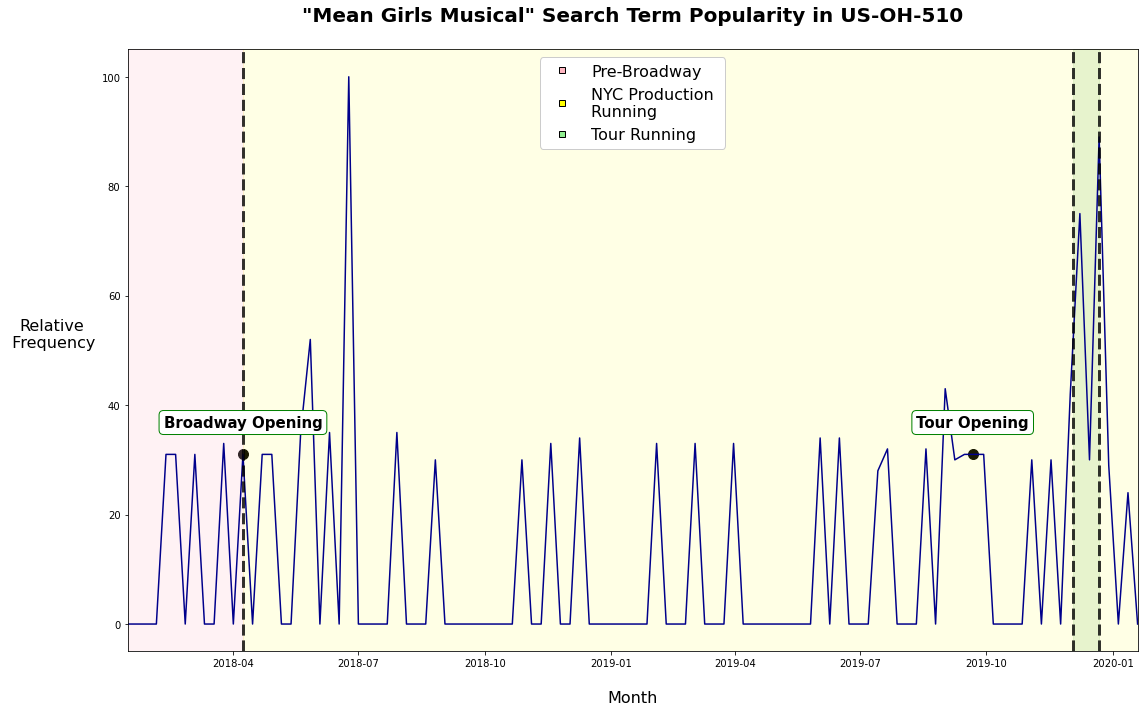

In [23]:
# IMPORT necessary packages
import seaborn as sns
import matplotlib.pyplot as plt
from project_functions import closest_date

# SET Axis size and xlimits
fig, ax = plt.subplots(figsize=(16,10))
plt.xlim(interest_over_time_df.index[0],interest_over_time_df.index[-1])

# Use external function to determine nearest date to actual opening
tour_opening_closest = closest_date(tour_opening, interest_over_time_df)
nyc_opening_closest = closest_date(nyc_opening, interest_over_time_df)

# GRAPH line plot for search data over time period, and points for Tour and Broadway opening
sns.lineplot(data=interest_over_time_df, x='date', y='frequency', color='darkblue')
plt.scatter(x=tour_opening, y=tour_opening_closest, s=100, c='black')
plt.scatter(x=nyc_opening, y=nyc_opening_closest, s=100, c='black')

# Create labels for Tour and Broadway Opening
ax.text(tour_opening, tour_opening_closest+5, "Tour Opening", horizontalalignment='center', fontsize=15, color='black', 
        weight='semibold', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round'))
ax.text(nyc_opening, nyc_opening_closest+5, "Broadway Opening", horizontalalignment='center', fontsize=15, color='black', 
        weight='semibold', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round'))

# Set titles and X/Y labels
ax.set_title(f'"{show_title[0]}" Search Term Popularity in {location_tag}\n', fontsize = 20, weight='bold')
ax.set_xlabel('\nMonth', fontsize=16)
ax.set_ylabel('Relative\n Frequency', fontsize=16, rotation=0, labelpad=50)

# Set vertical lines and highlighted regions corresponding to Broadway and National Tour running dates
ax.axvline(x=tour_venue_opening, linewidth=3, color='black', alpha=.8, linestyle='--')
ax.axvline(x=tour_venue_closing, linewidth=3, color='black', alpha=.8, linestyle='--')
ax.axvspan(tour_venue_opening,tour_venue_closing, color ='green',alpha=.1)
ax.axvspan(interest_over_time_df.index[0],nyc_opening, color ='pink',alpha=.2)
ax.axvline(x=nyc_opening, linewidth=3, color='black', alpha=.8, linestyle='--')

# If NYC production has closed, include closing date - otherwise, do not include 
if nyc_closing == 'N/A':
    ax.axvspan(nyc_opening, interest_over_time_df.index[-1], color ='yellow',alpha=.1)
else:
    ax.axvline(x=nyc_closing, linewidth=3, color='black', alpha=.8, linestyle='--')
    ax.axvspan(nyc_opening, nyc_closing, color ='yellow',alpha=.1)
    
# Create legend
colors = ['lightpink', 'yellow', 'lightgreen']
regions = ['Pre-Broadway', 'NYC Production \nRunning ', 'Tour Running']
handlelist = [plt.plot([], marker="s", ls="", color=color, markeredgewidth=1, 
                       markeredgecolor='black')[0] for color in colors]
plt.legend(handlelist,regions,loc='best', prop={"size":16}, framealpha=1, facecolor='white')

# Set tight layout and SAVE 
plt.tight_layout()
plt.savefig(f'visualizations/search_term_by_area/{show_title[0].strip()} {location_tag}'.replace(' ', '_')
           .replace('-','_'));
;

## Polarity Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#plt.xlim(-1,20)

sns.barplot(out.index, out.values, palette='rocket')
ax.set_yscale('log')



ax.axvspan(-1,8, color ='orange',alpha=.1)
ax.axvspan(8,11, color ='gray',alpha=.1)
ax.axvspan(11,20, color ='red',alpha=.1)
ax.set(xticklabels=['','','','','Negative','','','','','','Neutral','','','','','','Positive','','',''], yticklabels=[])
ax.set_xticks(list(np.linspace(0,20,11)))
ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()

cashtag_no_dollar = cashtag[1:]

plt.savefig(f'images/cashtags/polarity_distribution_{cashtag_no_dollar}');
